In [73]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape

# metodo de clasificacion
import jenkspy

In [83]:
# Cargar el shapefile que contiene el polígono para el recorte
shapefile_path = r'C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\test_estimativas\campodulce.shp'
poligono = gpd.read_file(shapefile_path)

In [89]:
# Cargar el raster (NDVI)
raster_path = r'C:\Users\bismarksr\Downloads\NDVI_02_2025_UTM.tif'
with rasterio.open(raster_path) as src:
    # El polígono debe estar en formato GeoJSON para la función mask
    geometrias = [geom.__geo_interface__ for geom in poligono.geometry]

    # Crear la máscara para múltiples polígonos
    out_image, out_transform = mask(src, geometrias, crop=True)

    # Copiar los metadatos del raster original para el nuevo archivo
    out_meta = src.meta.copy()

In [84]:
# Cargar el raster (NDVI)
raster_path = r'C:\Users\bismarksr\Downloads\NDVI_02_2025_UTM.tif'
with rasterio.open(raster_path) as src:
    # El polígono debe estar en formato GeoJSON para la función mask
    geometrias = [poligono.geometry.values[0].__geo_interface__]
    # Crear la máscara
    out_image, out_transform = mask(src, geometrias, crop=True)
    # Copiar los metadatos del raster original para el nuevo archivo
    out_meta = src.meta.copy()

AttributeError: 'GeometryArray' object has no attribute '__geo_interface__'

In [90]:
# Actualizar los metadatos para reflejar las nuevas dimensiones y transformación
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [91]:
# Guardar el raster recortado en un nuevo archivo
output_path = r'C:\Test\res.tif'
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [92]:
# Ruta al archivo .tif
raster_path = r'C:\Test\res.tif'

In [93]:
# Leer el archivo .tif
with rasterio.open(raster_path) as src:
    ndvi = src.read(1)  # Leer la primera banda; NDVI suele estar en una sola banda

In [94]:
# Aplicar una máscara para excluir los valores 0
ndvi_masked = np.ma.masked_equal(ndvi, 0)

In [95]:
len(ndvi_masked)

337

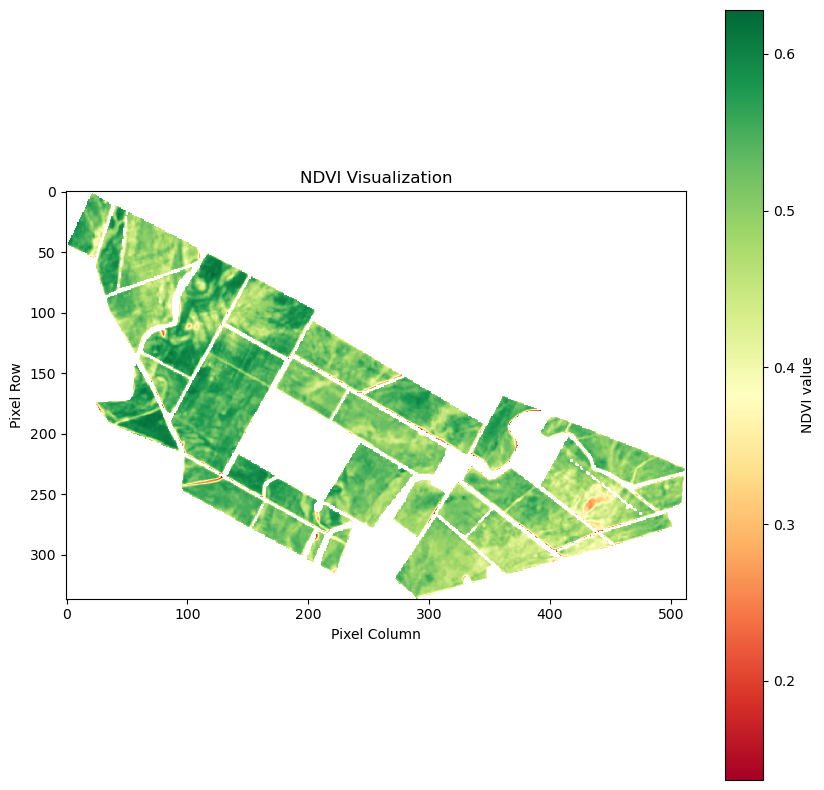

In [96]:
# Mostrar los datos de NDVI como una imagen, excluyendo los valores 0
plt.figure(figsize=(10, 10))
plt.imshow(ndvi_masked, cmap='RdYlGn')
plt.colorbar(label='NDVI value')
plt.title('NDVI Visualization')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

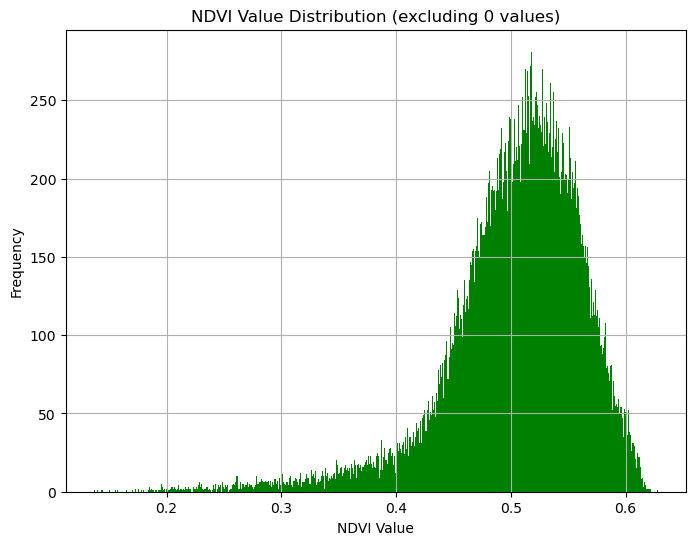

In [97]:
# Histograma de los valores de NDVI, excluyendo los valores 0
plt.figure(figsize=(8, 6))
plt.hist(ndvi_masked.compressed(), bins=1000, color='green')
plt.title('NDVI Value Distribution (excluding 0 values)')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [106]:
# Función para clasificar la imagen NDVI
def classify_ndvi(ndvi, thresholds):
    classified = np.digitize(ndvi, bins=thresholds)
    return classified.astype(np.int16)  # Asegurar el dtype correcto

# Cargar la imagen NDVI
ndvi_path = r'C:\Test\res.tif'
with rasterio.open(ndvi_path) as ndvi_src:
    ndvi = ndvi_src.read(1)  # NDVI en la primera banda
    transform = ndvi_src.transform

# Definir los umbrales de clasificación y clasificar
# excluye valores cero
ndvi_values = ndvi[ndvi != 0]
# convierte valores ndvi a lista
ndvi_list = ndvi_values.flatten().tolist()

thresholds = jenkspy.jenks_breaks(ndvi_list, n_classes=8)

thresholds = [0.13677845718754872,
 0.30222100320311174,
 0.38149394951370785,
 0.4355219670914465,
 0.47389505186161257,
 0.5052590197137777,
 0.5349060162489991,
 0.5664683695380378]

classified_ndvi = classify_ndvi(ndvi, thresholds)

# Convertir la clasificación NDVI a polígonos
mask = classified_ndvi > 0  # Excluir la clase '0' si es "no data"
polygons = shapes(classified_ndvi, mask=mask, transform=transform)

# Crear GeoDataFrame de los polígonos
polys = list(polygons)
gdf = gpd.GeoDataFrame([{'geometry': shape(polygon), 'class': value} for polygon, value in polys])

# Cargar el polígono del lote desde un archivo Shapefile y asegurar el mismo CRS
lote_gdf = gpd.read_file(r'C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\test_estimativas\campodulce.shp')
gdf.crs = lote_gdf.crs

# Intersectar los polígonos clasificados con el lote
intersection_gdf = gpd.overlay(gdf, lote_gdf, how="intersection")

# Calcular el área de cada polígono en la intersección en hectáreas
intersection_gdf["area_ha"] = intersection_gdf.area / 10000

# Imprimir o guardar el GeoDataFrame resultante
print(intersection_gdf[['class', 'area_ha']])

      class   area_ha
0       4.0  0.017266
1       4.0  0.009419
2       5.0  0.087908
3       5.0  0.006153
4       6.0  0.005581
...     ...       ...
8336    2.0  0.161212
8337    1.0  0.015469
8338    2.0  0.111652
8339    1.0  0.009012
8340    3.0  0.005422

[8341 rows x 2 columns]


In [107]:
thresholds

[0.13677845718754872,
 0.30222100320311174,
 0.38149394951370785,
 0.4355219670914465,
 0.47389505186161257,
 0.5052590197137777,
 0.5349060162489991,
 0.5664683695380378]

In [108]:
set(intersection_gdf['class'])

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}

<Axes: >

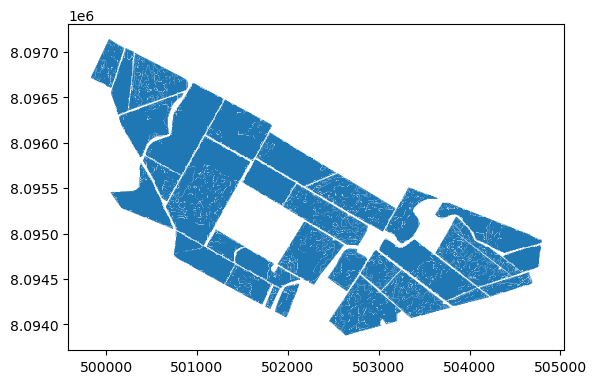

In [109]:
intersection_gdf.plot()

In [110]:
intersection_gdf.to_file("res_campodulce_12-3.shp", driver="ESRI Shapefile")